# Support Vector Machines

In this chapter you will learn all about the details of support vector machines. You'll learn about tuning hyperparameters for these models and using kernels to fit non-linear decision boundaries.

Linear SVM use the hinge loss and L2 Regularization.

A way of defining support vectors is that they include incorrectly classified examples, as well as correctly classified examples that are close to the boundary. If you're wondering how close is considered close enough, this is controlled by the regularization strength.

## Support vector definition

Which of the following is a true statement about support vectors? To help you out, here's the picture of support vectors from the video (top), as well as the hinge loss from Chapter 2 (bottom).

![SVM Definition](svm_def_sv.png)
![Hing loss](diagram_hinge_loss.png)

All incorrectly classified points are support vectors.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.svm import SVC

In [8]:
def make_meshgrid(x, y, h=.02, lims=None):
    """Create a mesh of points to plot in
    
    Parameters
    ----------
        x: data to base x-axis meshgrid on
        y: data to base y-axis meshgrid on
        h: stepsize for meshgrid, optional
        
    Returns
    -------
        xx, yy : ndarray
    """
    
    if lims is None:
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
    else:
        x_min, x_max, y_min, y_max = lims
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, proba=False, **params):
    """Plot the decision boundaries for a classifier.
    
    Parameters
    ----------
        ax: matplotlib axes object
        clf: a classifier
        xx: meshgrid ndarray
        yy: meshgrid ndarray
        params: dictionary of params to pass to contourf, optional
    """
    if proba:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,-1]
        Z = Z.reshape(xx.shape)
        out = ax.imshow(Z,extent=(np.min(xx), np.max(xx), np.min(yy), np.max(yy)), 
                        origin='lower', vmin=0, vmax=1, **params)
        ax.contour(xx, yy, Z, levels=[0.5])
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_classifier(X, y, clf, ax=None, ticks=False, proba=False, lims=None): 
    # assumes classifier "clf" is already fit
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1, lims=lims)
    
    if ax is None:
        plt.figure(figsize=(12,8))
        ax = plt.gca()
        show = True
    else:
        show = False
        
    # can abstract some of this into a higher-level function for learners to call
    cs = plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8, proba=proba)
    if proba:
        cbar = plt.colorbar(cs)
        cbar.ax.set_ylabel('probability of red $\Delta$ class', fontsize=20, rotation=270, labelpad=30)
        cbar.ax.tick_params(labelsize=14)
        #ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=30, edgecolors=\'k\', linewidth=1)
    labels = np.unique(y)
    if len(labels) == 2:
        ax.scatter(X0[y==labels[0]], X1[y==labels[0]], cmap=plt.cm.coolwarm, 
                   s=60, c='b', marker='o', edgecolors='k')
        ax.scatter(X0[y==labels[1]], X1[y==labels[1]], cmap=plt.cm.coolwarm, 
                   s=60, c='r', marker='^', edgecolors='k')
    else:
        ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=50, edgecolors='k', linewidth=1)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    #     ax.set_xlabel(data.feature_names[0])
    #     ax.set_ylabel(data.feature_names[1])
    if ticks:
        ax.set_xticks(())
        ax.set_yticks(())
        #     ax.set_title(title)
    if show:
        plt.show()
    else:
        return ax

## Effect of removing examples

Support vectors are defined as training examples that influence the decision boundary. In this exercise, you'll observe this behavior by removing non support vectors from the training set.

The wine quality dataset is already loaded into X and y (first two features only). (Note: we specify lims in plot_classifier() so that the two plots are forced to use the same axis limits and can be compared directly.)

In [2]:
from sklearn.datasets import load_wine
data = load_wine()

In [5]:
X=data.data[:,0:2]
y=data.target

In [13]:
X.shape

(178, 2)

**Instructions**

* Train a linear SVM on the whole data set.
* Create a new data set containing only the support vectors.
* Train a new linear SVM on the smaller data set.

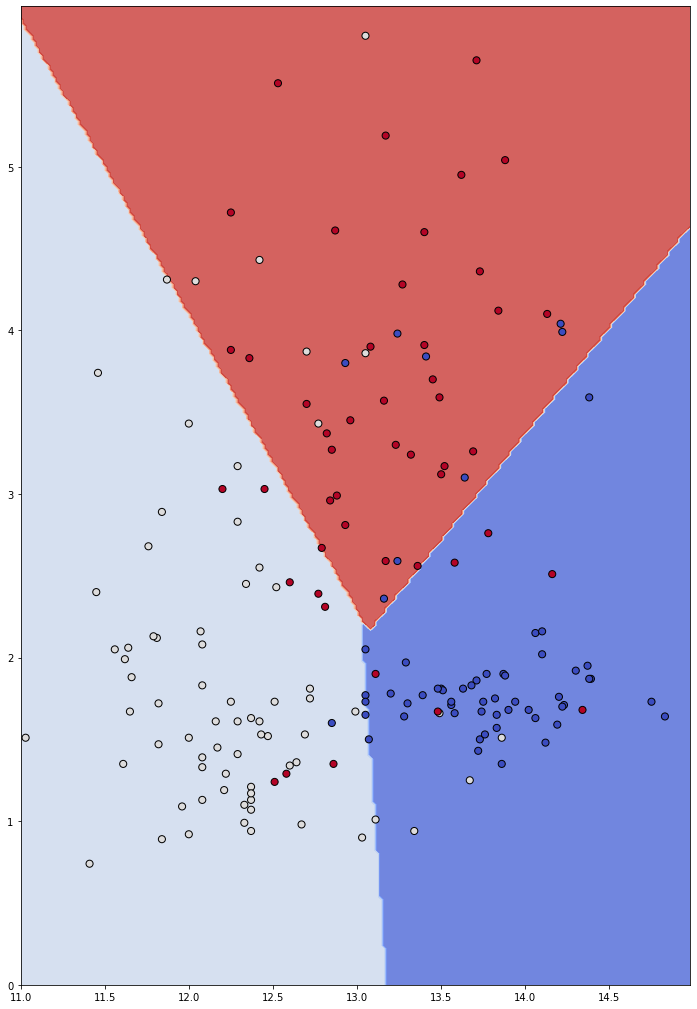

In [10]:
# Train a linear SVM
svm = SVC(kernel="linear")
svm.fit(X,y)
plot_classifier(X, y, svm, lims=(11,15,0,6))


In [12]:
svm.support_.shape

(81,)

Number of original examples 178
Number of support vectors 81


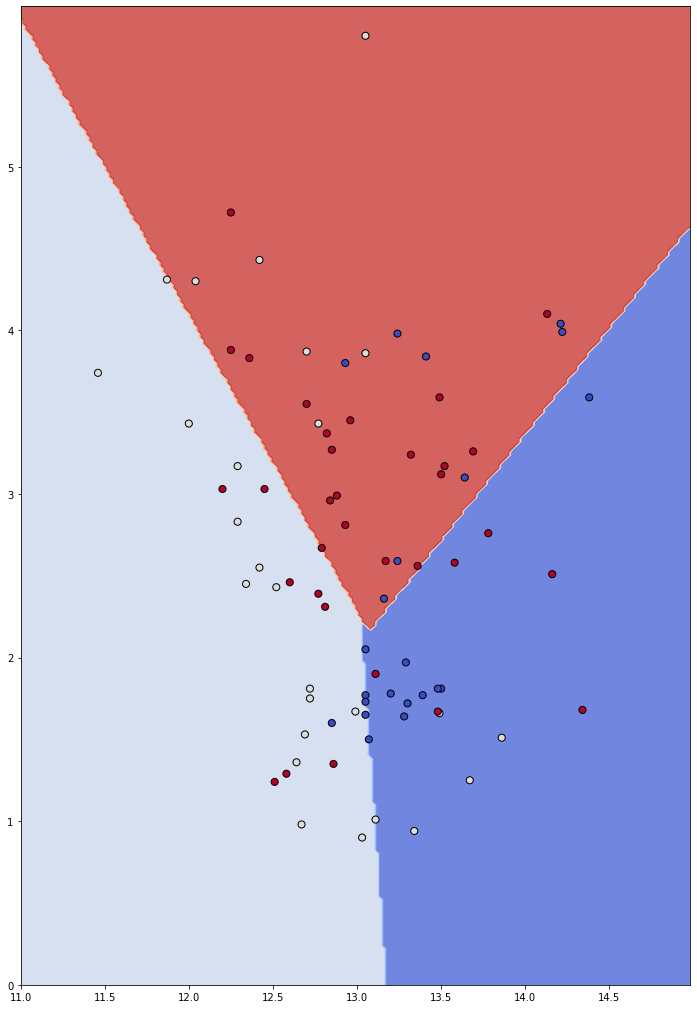

In [14]:
# Make a new data set keeping only the support vectors
print("Number of original examples", len(X))
print("Number of support vectors", len(svm.support_))
X_small = X[svm.support_]
y_small = y[svm.support_]

# Train a new SVM using only the support vectors
svm_small = SVC(kernel="linear")
svm_small.fit(X_small,y_small)
plot_classifier(X_small, y_small, svm_small, lims=(11,15,0,6))

 Compare the decision boundaries of the two trained models: are they the same? By the definition of support vectors, they should be!

## Kernel SVMs

![Transforming your features](SVM_Transformed.png)

what does this linear boundary look like back in the original space. In other words, if we took these axes and un-squared them, what would happen to the shape of the boundary?

In this case, we get an ellipse. So, what's the take-home message here? It's that fitting a linear model in a transformed space corresponds to fitting a nonlinear model in the original space. Nice! In general, the transformation isn't always going to be squaring and the boundary isn't always going to be an ellipse. In fact, the new space often has a different number of dimensions from the original space! But this is the basic idea. Kernels and kernel SVMs implement feature transformations in a computationally efficient way.


Using SKlearn SVC class to allow for different kernel.
The default kernel is rbf, the rbf has a hyperparameter called gamma,gamma controls the smootness of the boundary, by decreasing gamma we can make the boundary smoother.

![Kernel SVMs](Kernel_SVM_RBF.png)

as seen gamma=0.01 is smoother.
rbf svms can almost seperate any dataset, but be cearfull of overfitting.

## GridSearchCV warm-up

In the video we saw that increasing the RBF kernel hyperparameter gamma increases training accuracy. In this exercise we'll search for the gamma that maximizes cross-validation accuracy using scikit-learn's GridSearchCV. A binary version of the handwritten digits dataset, in which you're just trying to predict whether or not an image is a "2", is already loaded into the variables X and y.

In [17]:
from sklearn.datasets import load_digits

data=load_digits()
X=data.data
y=data.target
X.shape

(1797, 64)

In [19]:
X=X[0:898]
y=y[0:898]

In [21]:
from sklearn.model_selection import GridSearchCV

**Instructions**

* Create a GridSearchCV object.
* Call the fit() method to select the best value of gamma based on cross-validation accuracy.

In [22]:
# Instantiate an RBF SVM
svm = SVC()

# Instantiate the GridSearchCV object and run the search
parameters = {'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1]}
searcher = GridSearchCV(svm, parameters)
searcher.fit(X,y)

# Report the best parameters
print("Best CV params", searcher.best_params_)

Best CV params {'gamma': 0.001}


Larger values of gamma are better for training accuracy, but cross-validation helped us find something different (and better!)

## Jointly tuning gamma and C with GridSearchCV

In the previous exercise the best value of gamma was 0.001 using the default value of C, which is 1. In this exercise you'll search for the best combination of C and gamma using GridSearchCV.

As in the previous exercise, the 2-vs-not-2 digits dataset is already loaded, but this time it's split into the variables X_train, y_train, X_test, and y_test. Even though cross-validation already splits the training set into parts, it's often a good idea to hold out a separate test set to make sure the cross-validation results are sensible.

In [23]:
data=load_digits()
X=data.data
y=data.target

In [24]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.50)
X_train,X_test=np.array(X_train),np.array(X_test)
y_train,y_test=np.array(y_train),np.array(y_test)

**Instructions**

* Run GridSearchCV to find the best hyperparameters using the training set.
* Print the best values of the parameters.
* Print out the accuracy on the test set, which was not used during the cross-validation procedure.

In [25]:
# Instantiate an RBF SVM
svm = SVC()

# Instantiate the GridSearchCV object and run the search
parameters = {'C':[0.1, 1, 10], 'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1]}
searcher = GridSearchCV(svm, parameters)
searcher.fit(X_train,y_train)

# Report the best parameters and the corresponding score
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)

# Report the test accuracy using these best parameters
print("Test accuracy of best grid search hypers:", searcher.score(X_test,y_test))

Best CV params {'C': 10, 'gamma': 0.001}
Best CV accuracy 0.9933209186840471
Test accuracy of best grid search hypers: 0.9899888765294772


Note that the best value of gamma, 0.0001, is different from the value of 0.001 that we got in the previous exercise, when we fixed C=1. Hyperparameters can affect each other!

## Comparing logistic regression and SVM (and beyond)

**Logistic regression in sklearn:**

linear_model.LogisticRegression

Key hyperparameters in sklearn:
* C (inverse regularization strength)
* penalty (type of regularization)
* multi_class (type of multi-class)
  
SVM in sklearn:

* svm.LinearSVC and svm.SVC

Key hyperparameters in sklearn:

* C (inverse regularization strength)
* kernel (type of kernel)
* gamma (inverse RBF smoothness)

SGDClassifier(Stocastic gradient desent): can handle large datasets. used for both Logistic(loss='log') and SVM (loss='hinge')
SGDClassifier hyperparameter alpha is like 1/C

Having a limited number of support vectors makes kernel SVMs computationally efficient. so thus can be faster than logistic regression. 

while Logistic regression naturally outputs meaningful probabilities better than SVMs

## Using SGDClassifier

In this final coding exercise, you'll do a hyperparameter search over the regularization type, regularization strength, and the loss (logistic regression vs. linear SVM) using SGDClassifier().

**Instructions**

* Instantiate an SGDClassifier instance with random_state=0.
* Search over the regularization strength, the hinge vs. log losses, and L1 vs. L2 regularization.

In [26]:
from sklearn.linear_model import SGDClassifier

In [28]:
# We set random_state=0 for reproducibility 
linear_classifier = SGDClassifier(random_state=0,max_iter=10000)

# Instantiate the GridSearchCV object and run the search
parameters = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
             'loss':['hinge','log'], 'penalty':['l1','l2']}
searcher = GridSearchCV(linear_classifier, parameters, cv=10)
searcher.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)
print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))

Best CV params {'alpha': 0.001, 'loss': 'log', 'penalty': 'l2'}
Best CV accuracy 0.9577153558052436
Test accuracy of best grid search hypers: 0.9510567296996663


Best CV params {'alpha': 0.001, 'loss': 'log', 'penalty': 'l2'}

One advantage of SGDClassifier is that it's very fast - this would have taken a lot longer with LogisticRegression or LinearSVC.